# Adaptive Moment Estimation (Adam) for Deep Long Short Term Networks

## Import Dependencies

In [86]:
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import pandas as pd
import pickle
import plotly.graph_objects as go
import yaml

import json

## General Setup

In [87]:
with open('config.yaml', 'rb') as file:
    config = yaml.safe_load(file)

In [88]:
config

{'DATA': {'BCC': 'IDR',
  'END_DATE': datetime.date(2023, 4, 30),
  'MAX_DATA': 16718.5,
  'MIN_DATA': 11337.5,
  'SCC': 'USD',
  'START_DATE': datetime.date(2014, 4, 30),
  'TEST': 0.2,
  'TRAIN': 0.8},
 'MODEL': {'CHECKPOINT': {'HIDDEN_1': 64,
   'HIDDEN_2': 32,
   'INPUT': 7,
   'OUTPUT': 1},
  'DROPOUT': 0.2,
  'EPOCHS': 100,
  'HIDDEN_LAYER': 2,
  'HIDDEN_SIZE': [8, 16, 32, 64],
  'INPUT_SIZE': [7, 14, 30],
  'LEARNING_RATE': [0.1, 0.01, 0.001],
  'MODEL_NAME': '',
  'OPTIM_FUNC': 'Adam',
  'OUTPUT_SIZE': 1},
 'TICKERS': ['USDIDR', 'JPYIDR'],
 'WEIGHT': {'SAVE_BEST': True, 'SAVE_WEIGHT_PATH': './models'}}

## Data Collection

- Crawling historical data dari https://ofx.com
- Visualisasi data yang telah didapatkan

In [89]:
# collect data
from utils.data_generator import ofx_dataset
from datetime import datetime
from time import time

In [90]:
start_date= config["DATA"]["START_DATE"]
end_date = config["DATA"]["END_DATE"]

In [91]:
start_date = int( datetime.combine(start_date, datetime.min.time()).timestamp() ) * 1000
end_date   = int( datetime.combine(end_date, datetime.min.time()).timestamp() ) * 1000

In [92]:
datasets = ofx_dataset(start_date, end_date)

200


In [93]:
datasets['timestamps'] = pd.to_datetime(datasets['timestamps'], unit='s')
datasets.set_index('timestamps', inplace=True)
datasets.head()

,values
timestamps,
2014-04-30,11523.0
2014-05-01,11538.0
2014-05-02,11523.0
2014-05-03,11530.0
2014-05-04,11525.0


In [94]:
datasets.shape

(3256, 1)

### Function visualisasi data

In [105]:
def linechart(data: pd.DataFrame):
    plt.figure(figsize=(20, 6))
    plt.plot(data.index, datasets.values)
    
    plt.xlabel("Histories")
    plt.ylabel("Values")
    plt.title("Historical Data")
    plt.show()

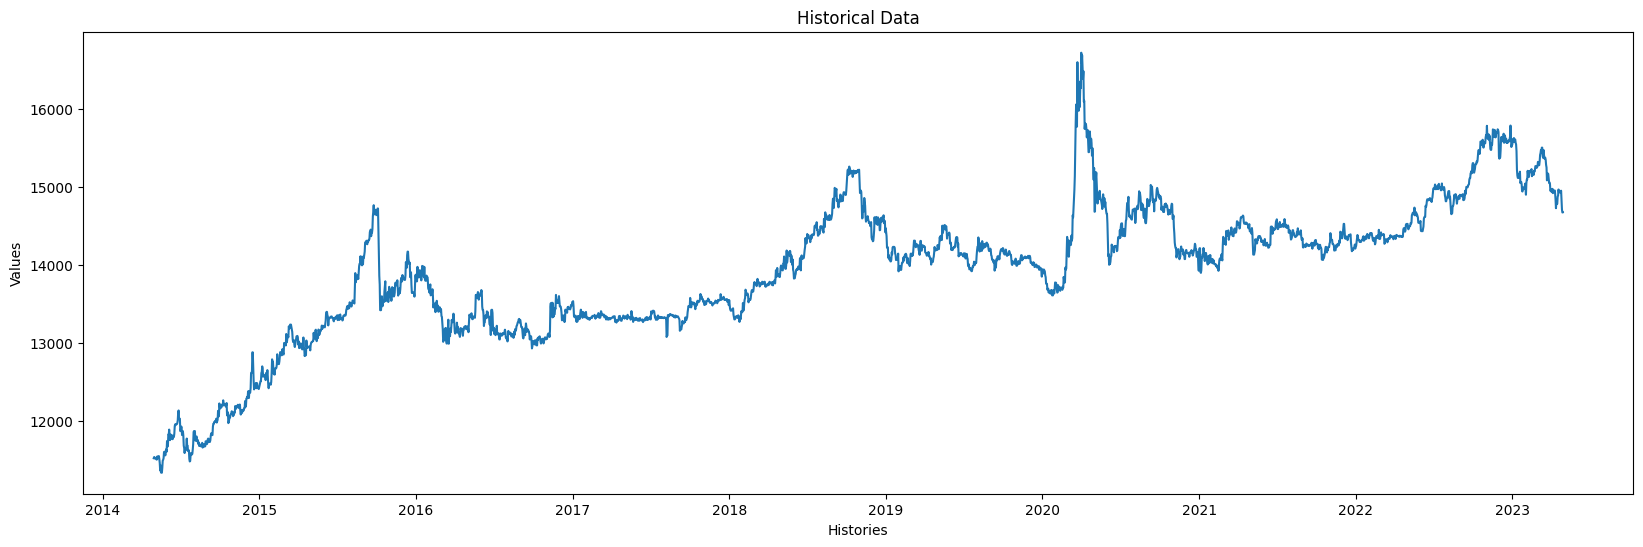

In [106]:
linechart(datasets)

## Normalisasi Data
- normalisasi data menjadi skala -1 hingga 1

In [12]:
import numpy as np

class MinMaxScaler:

    def __init__(self, min_val=-1,  max_val=1):
        self.min_val = min_val
        self.max_val = max_val
        self.min_data = None
        self.max_data = None

    def fit(self, data):
        self.min_data = min(data)
        self.max_data = max(data)
        config['DATA'][f'MIN_DATA'] = self.min_data
        config['DATA'][f'MAX_DATA'] = self.max_data
        with open('config.yaml', 'w') as file:
            yaml.dump(config, file)

    def transform(self, data):
        scaled_data = (data - self.min_data) / (self.max_data - self.min_data)
        scaled_data = scaled_data * (self.max_val - self.min_val) + self.min_val
        return scaled_data

    def inverse_transform(self, scaled_data, min_data=None, max_data=None):
        if min_data:
            self.min_data = min_data
        if max_data:
            self.max_data = max_data

        data = ( scaled_data - self.min_val ) / ( self.max_val - self.min_val )
        data = data * ( self.max_data - self.min_data ) + self.min_data
        return data

In [13]:
# scaling datasets
data_scaler = MinMaxScaler(min_val=-1, max_val=1)
data_scaler.fit(datasets['values'])
datasets['normalized'] = data_scaler.transform(datasets['values'])

In [14]:
datasets.head()

,values,normalized
timestamps,,
2014-04-30,11523.0,-0.931054
2014-05-01,11538.0,-0.925479
2014-05-02,11523.0,-0.931054
2014-05-03,11530.0,-0.928452
2014-05-04,11525.0,-0.930310


## Sliding Window

In [15]:
# Modul Sliding Window
def sliding_window(data, window_size):
    X = []
    y = []
    for i in range(len(data) - window_size):
        X.append(data[ i : i+window_size ])
        y.append(data[ i + window_size ])
    X = np.array(X)
    y = np.array(y)
    X_reshape = X.reshape(X.shape[0], X.shape[1], 1)
    y_reshape = y.reshape(y.shape[0], 1)
    return torch.from_numpy(X_reshape).type(torch.Tensor), torch.from_numpy(y_reshape).type(torch.Tensor)

In [16]:
## Sliding Window

for i in config["MODEL"]["INPUT_SIZE"]:
    vars()[f"X_slide_{i}"], vars()[f"y_slide_{i}"] = sliding_window(datasets.normalized, window_size=i)

In [17]:
X_slide_7.shape, X_slide_14.shape, X_slide_30.shape

(torch.Size([3249, 7, 1]),
 torch.Size([3242, 14, 1]),
 torch.Size([3226, 30, 1]))

## Data Spliting
- Split data yang telah didapatkan, menjadi 80% training dan 20% testing
- Visualisasi data yang telah dibagi
- Menghasilkan dataset sebanyak input yang diinginkan

In [18]:
# proses split data
for i in config["MODEL"]["INPUT_SIZE"]:
    size_ = vars()[f"X_slide_{i}"].shape[0]
    print("setup data", size_)
    Xdataset = vars()[f"X_slide_{i}"]
    ydataset = vars()[f"y_slide_{i}"]
    train_size = round(config['DATA']["TRAIN"] * size_)
    
    vars()[f"X_train_{i}"] = Xdataset[:train_size]
    vars()[f"X_test_{i}"]  = Xdataset[train_size:]

    vars()[f"y_train_{i}"] = ydataset[:train_size]
    vars()[f"y_test_{i}"]  = ydataset[train_size:]

setup data 3249
setup data 3242
setup data 3226


### Vis Datasets

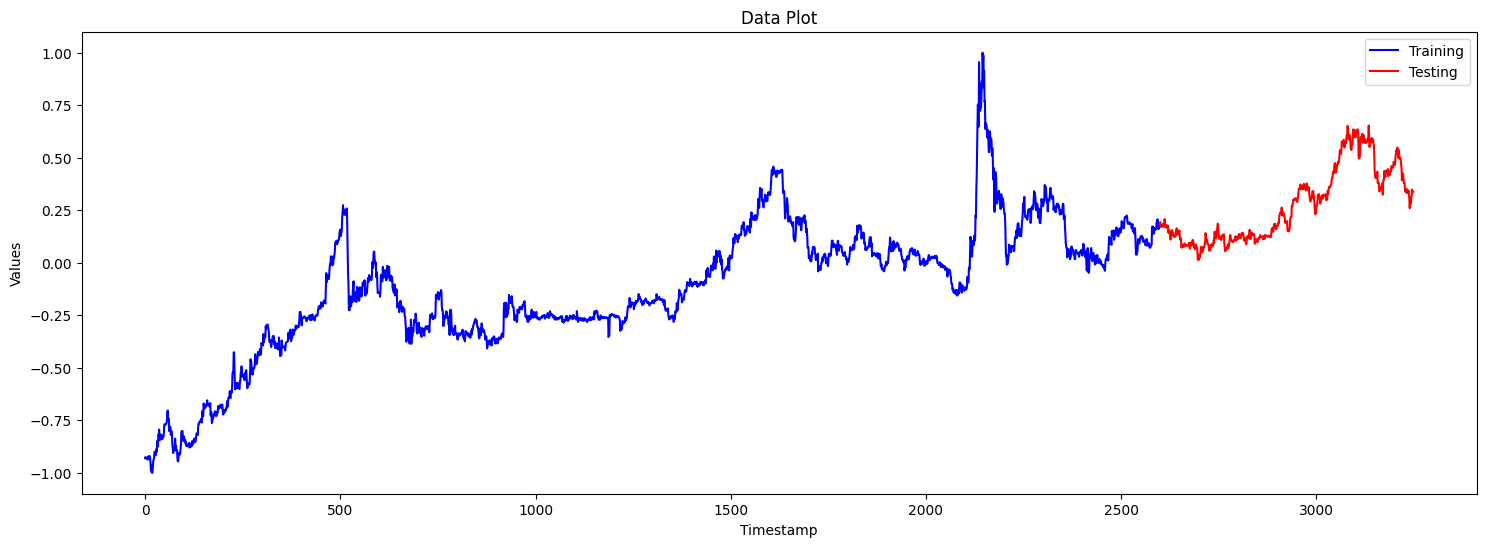

In [19]:
# proses visualisasi data
plt.figure(figsize=(18, 6))

# Mengambil data dari tensor dan mengubahnya menjadi array satu dimensi
train_data = X_train_7[:, 0, 0].flatten().numpy()
test_data = X_test_7[:, 0, 0].flatten().numpy()

# Mengatur posisi x untuk line chart
x_train = np.arange(len(train_data))
x_test = np.arange(len(train_data), len(train_data) + len(test_data))


# Membuat line chart
plt.plot(x_train, train_data, color='blue', label='Training')
plt.plot(x_test, test_data, color='red', label='Testing')


# Menambahkan label dan judul plot
plt.xlabel('Timestamp')
plt.ylabel('Values')
plt.title('Data Plot')
plt.legend()

# Menampilkan plot
plt.show()

# Modeling

## Generic LSTM

In [20]:
class LSTMModel(nn.Module):

    def __init__(self, input_size, hidden_sizes, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_sizes = hidden_sizes
        self.num_layers = len(hidden_sizes)
        self.lstms = nn.ModuleList()
        self.lstms.append(
            nn.LSTM(input_size, hidden_sizes[0])
        )

        for i in range(1, self.num_layers):
            self.lstms.append(
                nn.LSTM(hidden_sizes[i-1], hidden_sizes[i])
            )
        self.dropout = nn.Dropout(config['MODEL']['DROPOUT'])
        self.fc = nn.Linear(hidden_sizes[-1], output_size)
        self.init_weights()

    def init_weights(self):
        for i in range(self.num_layers):
            for name, param in self.lstms[i].named_parameters():
                if 'weight' in name:
                    if param.data.dim() > 1:
                        nn.init.xavier_normal_(param)
                    else:
                        nn.init.zeros_(param)
                elif 'bias' in name:
                    nn.init.constant_(param, 0)

    def forward(self, input):
        for i in range(self.num_layers):
            output, _ = self.lstms[i](input)
            input = output

        output = self.fc(output[:, -1, :])
        return output

## Uji Learning

In [21]:
# class UJI

class Evaluation:
    
    def __init__(self, prediction=[], actual=[]):
        self.prediction = prediction
        self.actual = actual

    def rmse(self):
        return np.sqrt(((self.prediction - self.actual) ** 2).mean())

    def mape(self):
        n_data = len(self.prediction)
        absolute_error = []
        percentage_error = []

        for i in range(n_data):
            absolute_error.append( abs(self.actual[i] - self.prediction[i]) )
            percentage_error.append( absolute_error[i] / abs(self.actual[i]) )
        mape = (sum(percentage_error) / len(self.actual)) * 100
        return mape

    def da(self):
        correct = 0
        total = len(self.actual)

        for i in range(total):
            change_actual = self.actual[i-1] - self.actual[i]
            change_predicted = self.prediction[i-1] - self.prediction[i]

            if (change_actual > 0 and change_predicted > 0) or ( change_actual < 0 and change_predicted < 0 ):
                correct += 1

        accuracy = correct / (total - 1) * 100
        return accuracy

    def r2(self):
        mean_actual = sum(self.actual) / len(self.actual)
        ss_total = sum((actual_value - mean_actual) ** 2 for actual_value in self.actual)
        ss_residual = sum((self.actual[i] - self.prediction[i]) ** 2 for i in range(len(self.actual)))
        r_squared = 1 - (ss_residual / ss_total)
        return r_squared


In [22]:
config

{'DATA': {'BCC': 'IDR',
  'END_DATE': datetime.date(2023, 4, 30),
  'MAX_DATA': 16718.5,
  'MIN_DATA': 11337.5,
  'SCC': 'USD',
  'START_DATE': datetime.date(2014, 4, 30),
  'TEST': 0.2,
  'TRAIN': 0.8},
 'MODEL': {'CHECKPOINT': {'HIDDEN_1': 64,
   'HIDDEN_2': 64,
   'INPUT': 7,
   'OUTPUT': 1},
  'DROPOUT': 0.2,
  'EPOCHS': 100,
  'HIDDEN_LAYER': 2,
  'HIDDEN_SIZE': [8, 16, 32, 64],
  'INPUT_SIZE': [7, 14, 30],
  'LEARNING_RATE': [0.1, 0.01, 0.001],
  'MODEL_NAME': '',
  'OPTIM_FUNC': 'Adam',
  'OUTPUT_SIZE': 1},
 'TICKERS': ['USDIDR', 'JPYIDR'],
 'WEIGHT': {'SAVE_BEST': True, 'SAVE_WEIGHT_PATH': './models'}}

In [26]:
for lr in config['MODEL']['LEARNING_RATE']:
    model = LSTMModel(
        input_size=1,
        hidden_sizes=[1],
        output_size=1
    )
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    loss_histories = []
    num_epochs = 1000
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        output = model(X_train_7)
        loss = criterion(output, y_train_7)
        loss.backward()
        optimizer.step()

        loss_histories.append(loss.item())

        if (epoch + 1) % 10 == 0:
            print(f"Epoch: {epoch+1}/{num_epochs}, Loss: {loss.item()}")

    with open(f"models/{config['DATA']['SCC']}/loss_histories_{lr}.pkl", 'wb') as f:
        pickle.dump(loss_histories, f)
    torch.save(model.state_dict(), f"models/{config['DATA']['SCC']}/lr_{lr}.pth")

Epoch: 10/1000, Loss: 0.015406398102641106
Epoch: 20/1000, Loss: 0.005575612187385559
Epoch: 30/1000, Loss: 0.0017272087279707193
Epoch: 40/1000, Loss: 0.0015577632002532482
Epoch: 50/1000, Loss: 0.0011473508784547448
Epoch: 60/1000, Loss: 0.0009729423909448087
Epoch: 70/1000, Loss: 0.0008414521580561996
Epoch: 80/1000, Loss: 0.0007929664570838213
Epoch: 90/1000, Loss: 0.0007625762955285609
Epoch: 100/1000, Loss: 0.0007409719401039183
Epoch: 110/1000, Loss: 0.0007260836428031325
Epoch: 120/1000, Loss: 0.0007141837268136442
Epoch: 130/1000, Loss: 0.0007050560670904815
Epoch: 140/1000, Loss: 0.0006975540309213102
Epoch: 150/1000, Loss: 0.0006912535172887146
Epoch: 160/1000, Loss: 0.0006857879925519228
Epoch: 170/1000, Loss: 0.0006809512851759791
Epoch: 180/1000, Loss: 0.0006765864090994
Epoch: 190/1000, Loss: 0.000672586727887392
Epoch: 200/1000, Loss: 0.0006688792491331697
Epoch: 210/1000, Loss: 0.0006654126918874681
Epoch: 220/1000, Loss: 0.0006621518987230957
Epoch: 230/1000, Loss: 0.

In [27]:
# import plotly.graph_objects as go

fig = go.Figure()
x = [x+1 for x in range(1000)]
# for lr in params["LR"]:
for lr in config['MODEL']["LEARNING_RATE"]:
    with open(f"models/{config['DATA']['SCC']}/loss_histories_{lr}.pkl", 'rb') as f:
        loss_histories = pickle.load(f)
    
        fig.add_trace(go.Scatter(x=x, y=loss_histories, mode='lines', name=f"loss histories of {lr}"))
        
        fig.update_layout(
            xaxis_title='epoch',
            yaxis_title='loss',
            title=f"Loss error {config['MODEL']['LEARNING_RATE']}",
            height=800
        )
fig.show()

## Uji Jumlah Feature Input dan Hidden Layer 1

### Training Model

In [52]:
config

{'DATA': {'BCC': 'IDR',
  'END_DATE': datetime.date(2023, 4, 30),
  'MAX_DATA': 16718.5,
  'MIN_DATA': 11337.5,
  'SCC': 'USD',
  'START_DATE': datetime.date(2014, 4, 30),
  'TEST': 0.2,
  'TRAIN': 0.8},
 'MODEL': {'CHECKPOINT': {'HIDDEN_1': 32,
   'HIDDEN_2': 64,
   'INPUT': 7,
   'OUTPUT': 1},
  'DROPOUT': 0.2,
  'EPOCHS': 100,
  'HIDDEN_LAYER': 2,
  'HIDDEN_SIZE': [8, 16, 32, 64],
  'INPUT_SIZE': [7, 14, 30],
  'LEARNING_RATE': [0.1, 0.01, 0.001],
  'MODEL_NAME': '',
  'OPTIM_FUNC': 'Adam',
  'OUTPUT_SIZE': 1},
 'TICKERS': ['USDIDR', 'JPYIDR'],
 'WEIGHT': {'SAVE_BEST': True, 'SAVE_WEIGHT_PATH': './models'}}

In [53]:
for window in config['MODEL']['INPUT_SIZE']:

    for hidden_size in config['MODEL']['HIDDEN_SIZE']:
        model = LSTMModel(
            input_size=1,
            hidden_sizes=[hidden_size],
            output_size=config['MODEL']['OUTPUT_SIZE']
        )
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=.001)

        loss_histories = []
        num_epochs = config['MODEL']['EPOCHS']
        for epoch in range(num_epochs):
            model.train()
            optimizer.zero_grad()
            output = model(vars()[f"X_train_{window}"])
            loss = criterion(output, vars()[f"y_train_{window}"])
            loss.backward()
            optimizer.step()

            loss_histories.append(loss.item())

            if (epoch + 1) % 10 == 0:
                print(f"Epoch: {epoch + 1}/{num_epochs}, Loss: {loss.item()}")

        with open(f"models/{config['DATA']['SCC']}/hist_{window}_{hidden_size}.pkl", 'wb') as file:
            pickle.dump(loss_histories, file)
        torch.save(model.state_dict(), f"models/{config['DATA']['SCC']}/{window}_{hidden_size}.pth")

Epoch: 10/100, Loss: 0.1281312108039856
Epoch: 20/100, Loss: 0.11435773968696594
Epoch: 30/100, Loss: 0.1014285683631897
Epoch: 40/100, Loss: 0.08944825083017349
Epoch: 50/100, Loss: 0.07852243632078171
Epoch: 60/100, Loss: 0.06814640015363693
Epoch: 70/100, Loss: 0.05657164752483368
Epoch: 80/100, Loss: 0.04178862273693085
Epoch: 90/100, Loss: 0.023950712755322456
Epoch: 100/100, Loss: 0.010853317566215992
Epoch: 10/100, Loss: 0.13836003839969635
Epoch: 20/100, Loss: 0.10788514465093613
Epoch: 30/100, Loss: 0.0730753093957901
Epoch: 40/100, Loss: 0.03690904751420021
Epoch: 50/100, Loss: 0.026597879827022552
Epoch: 60/100, Loss: 0.015230844728648663
Epoch: 70/100, Loss: 0.010210846550762653
Epoch: 80/100, Loss: 0.008304445073008537
Epoch: 90/100, Loss: 0.007619007024914026
Epoch: 100/100, Loss: 0.007016241550445557
Epoch: 10/100, Loss: 0.11581732332706451
Epoch: 20/100, Loss: 0.0947575643658638
Epoch: 30/100, Loss: 0.07081399112939835
Epoch: 40/100, Loss: 0.045184556394815445
Epoch: 50

### Evaluasi Hasil Input dan Hidden Layer ke 1
<ul>
    <li>Dilakukan dengan cara perulangan kombinasi dari jumlah input dan jumlah hidden pertama. </li>
    <li>kemudian dilakukan evaluasi dengan matriks RMSE, MAPE dan DA </li>
</ul>

In [54]:
config

{'DATA': {'BCC': 'IDR',
  'END_DATE': datetime.date(2023, 4, 30),
  'MAX_DATA': 16718.5,
  'MIN_DATA': 11337.5,
  'SCC': 'USD',
  'START_DATE': datetime.date(2014, 4, 30),
  'TEST': 0.2,
  'TRAIN': 0.8},
 'MODEL': {'CHECKPOINT': {'HIDDEN_1': 32,
   'HIDDEN_2': 64,
   'INPUT': 7,
   'OUTPUT': 1},
  'DROPOUT': 0.2,
  'EPOCHS': 100,
  'HIDDEN_LAYER': 2,
  'HIDDEN_SIZE': [8, 16, 32, 64],
  'INPUT_SIZE': [7, 14, 30],
  'LEARNING_RATE': [0.1, 0.01, 0.001],
  'MODEL_NAME': '',
  'OPTIM_FUNC': 'Adam',
  'OUTPUT_SIZE': 1},
 'TICKERS': ['USDIDR', 'JPYIDR'],
 'WEIGHT': {'SAVE_BEST': True, 'SAVE_WEIGHT_PATH': './models'}}

#### Uji hasil prediksi

In [55]:
# load semua model dengan identifikasi layer ke 1
buckets = {
    "model": [],
    "RMSE": [],
    "MAPE": [],
    "DA": [],
    "R2": []
}
for window in config['MODEL']['INPUT_SIZE']:

    for hidden_1 in config['MODEL']['HIDDEN_SIZE']:
        model = LSTMModel(
            input_size=1, hidden_sizes=[hidden_1], output_size=1
        )
        model.load_state_dict(torch.load(f"models/{config['DATA']['SCC']}/{window}_{hidden_1}.pth"))
        print("load model:", f"models/{config['DATA']['SCC']}/{window}_{hidden_1}.pth")
        with torch.no_grad():
            predicted = model.forward(vars()[f"X_test_{window}"])

        predicted_denorm = data_scaler.inverse_transform(predicted)
        actual_denorm = data_scaler.inverse_transform(vars()[f"y_test_{window}"])
        
        eval = Evaluation(actual=actual_denorm, prediction=predicted_denorm)
        buckets['model'].append(f"{window}_{hidden_1}")
        buckets['RMSE'].append(eval.rmse().item())
        buckets["MAPE"].append(eval.mape().item())
        buckets["DA"].append(eval.da())
        buckets["R2"].append(eval.r2().item())
        print(f"model {window}_{hidden_1}: rmse({eval.rmse().item()}) | mape({eval.mape().item()}) | da({eval.da()}) | r2({eval.r2()})")

load model: models/USD/7_8.pth
model 7_8: rmse(455.0525817871094) | mape(2.2222445011138916) | da(39.29121725731895) | r2(tensor([0.0608]))
load model: models/USD/7_16.pth
model 7_16: rmse(397.6111755371094) | mape(1.904117465019226) | da(40.06163328197226) | r2(tensor([0.2829]))
load model: models/USD/7_32.pth
model 7_32: rmse(268.990966796875) | mape(1.32537043094635) | da(40.67796610169492) | r2(tensor([0.6718]))
load model: models/USD/7_64.pth
model 7_64: rmse(108.31169891357422) | mape(0.536469578742981) | da(40.52388289676425) | r2(tensor([0.9468]))
load model: models/USD/14_8.pth
model 14_8: rmse(309.7862243652344) | mape(1.434224247932434) | da(40.1854714064915) | r2(tensor([0.5657]))
load model: models/USD/14_16.pth
model 14_16: rmse(389.38128662109375) | mape(1.864643931388855) | da(39.41267387944359) | r2(tensor([0.3138]))
load model: models/USD/14_32.pth
model 14_32: rmse(275.4614562988281) | mape(1.2781519889831543) | da(38.94899536321484) | r2(tensor([0.6566]))
load model

In [56]:
results = pd.DataFrame(buckets)
results.to_csv(f"{config['DATA']['SCC']}_{config['DATA']['BCC']}_input_layer1.csv")

In [57]:
results

,model,RMSE,MAPE,DA,R2
0,7_8,455.052582,2.222245,39.291217,0.060761
1,7_16,397.611176,1.904117,40.061633,0.282916
2,7_32,268.990967,1.325370,40.677966,0.671808
3,7_64,108.311699,0.536470,40.523883,0.946789
4,14_8,309.786224,1.434224,40.185471,0.565675
5,14_16,389.381287,1.864644,39.412674,0.313816
6,14_32,275.461456,1.278152,38.948995,0.656590
7,14_64,115.685051,0.568389,40.803709,0.939432
8,30_8,639.233215,3.651558,41.304348,-0.843653
9,30_16,424.115875,2.061404,39.906832,0.188423


In [115]:
# simpan input size dan hidden 1 ke yaml
best_input = 7
best_hidden_1 = 64
config['MODEL']['CHECKPOINT']['INPUT'] = best_input
config['MODEL']['CHECKPOINT']['HIDDEN_1'] = best_hidden_1

with open('./config.yaml', 'w') as file:
    yaml.dump(config, file)

#### Visualisasi best model

In [59]:
model = LSTMModel(
    input_size=1, hidden_sizes=[best_hidden_1], output_size=1
)
model.load_state_dict(torch.load(f'models/USD/{best_input}_{best_hidden_1}.pth'))

with torch.no_grad():
    predicted = model.forward(vars()[f"X_test_{best_input}"])

In [60]:
predict_denorm = data_scaler.inverse_transform(predicted)
actual_denorm = data_scaler.inverse_transform(vars()[f'y_test_{best_input}'])

eval = Evaluation(actual=actual_denorm, prediction=predicted_denorm)

In [61]:
fig = go.Figure()

x = [i for i in range(len(actual_denorm))]

fig.add_trace(go.Scatter(x=x, y=actual_denorm.squeeze(1), mode='lines', name="Actual"))
fig.add_trace(go.Scatter(x=x, y=predict_denorm.squeeze(1), mode='lines', name="Predicted"))

fig.update_layout(
    xaxis_title='timestep',
    # yaxis_title='values',
    yaxis = dict(
        title="values",
        tickformat=",.f2"
    ),
    title=f"LSTM Test (USD/IDR)",
    height=600
)
fig.show()

## Uji Hidden Layer 2

In [107]:
config

{'DATA': {'BCC': 'IDR',
  'END_DATE': datetime.date(2023, 4, 30),
  'MAX_DATA': 16718.5,
  'MIN_DATA': 11337.5,
  'SCC': 'USD',
  'START_DATE': datetime.date(2014, 4, 30),
  'TEST': 0.2,
  'TRAIN': 0.8},
 'MODEL': {'CHECKPOINT': {'HIDDEN_1': 64,
   'HIDDEN_2': 32,
   'INPUT': 7,
   'OUTPUT': 1},
  'DROPOUT': 0.2,
  'EPOCHS': 100,
  'HIDDEN_LAYER': 2,
  'HIDDEN_SIZE': [8, 16, 32, 64],
  'INPUT_SIZE': [7, 14, 30],
  'LEARNING_RATE': [0.1, 0.01, 0.001],
  'MODEL_NAME': '',
  'OPTIM_FUNC': 'Adam',
  'OUTPUT_SIZE': 1},
 'TICKERS': ['USDIDR', 'JPYIDR'],
 'WEIGHT': {'SAVE_BEST': True, 'SAVE_WEIGHT_PATH': './models'}}

In [63]:
for hidden_size in config['MODEL']['HIDDEN_SIZE']:
    model = LSTMModel(
        input_size=1,
        hidden_sizes=[best_hidden_1, hidden_size],
        output_size=config['MODEL']['OUTPUT_SIZE']
    )
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=.001)

    loss_histories = []
    num_epochs = config['MODEL']['EPOCHS']
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        output = model(vars()[f"X_train_{best_input}"])
        loss = criterion(output, vars()[f"y_train_{best_input}"])
        loss.backward()
        optimizer.step()

        loss_histories.append(loss.item())

        if (epoch + 1) % 10 == 0:
            print(f"Epoch: {epoch + 1}/{num_epochs}, Loss: {loss.item()}")

    with open(f"models/{config['DATA']['SCC']}/hist_{best_input}_{best_hidden_1}_{hidden_size}.pkl", 'wb') as file:
        pickle.dump(loss_histories, file)
    torch.save(model.state_dict(), f"models/{config['DATA']['SCC']}/{best_input}_{best_hidden_1}_{hidden_size}.pth")

Epoch: 10/100, Loss: 0.11787878721952438
Epoch: 20/100, Loss: 0.04624000936746597
Epoch: 30/100, Loss: 0.024640901014208794
Epoch: 40/100, Loss: 0.014749851077795029
Epoch: 50/100, Loss: 0.01013124454766512
Epoch: 60/100, Loss: 0.007851184345781803
Epoch: 70/100, Loss: 0.007017448078840971
Epoch: 80/100, Loss: 0.0065404134802520275
Epoch: 90/100, Loss: 0.006153879687190056
Epoch: 100/100, Loss: 0.005796006880700588
Epoch: 10/100, Loss: 0.11966685950756073
Epoch: 20/100, Loss: 0.04478628188371658
Epoch: 30/100, Loss: 0.025762980803847313
Epoch: 40/100, Loss: 0.011944078840315342
Epoch: 50/100, Loss: 0.009626479819417
Epoch: 60/100, Loss: 0.0077621969394385815
Epoch: 70/100, Loss: 0.007084657438099384
Epoch: 80/100, Loss: 0.006663557142019272
Epoch: 90/100, Loss: 0.006250572856515646
Epoch: 100/100, Loss: 0.005849730689078569
Epoch: 10/100, Loss: 0.07735124975442886
Epoch: 20/100, Loss: 0.039827000349760056
Epoch: 30/100, Loss: 0.013627270236611366
Epoch: 40/100, Loss: 0.0081175956875085

### Evaluasi Hasil Hidden Layer 2

#### Uji hasil prediksi

In [64]:
# load semua model dengan identifikasi layer ke 1
buckets = {
    "model": [],
    "RMSE": [],
    "MAPE": [],
    "DA": [],
    "R2": []
}

for hidden_2 in config['MODEL']['HIDDEN_SIZE']:
    model = LSTMModel(
        input_size=1, hidden_sizes=[best_hidden_1, hidden_2], output_size=1
    )
    model.load_state_dict(torch.load(f"models/{config['DATA']['SCC']}/{best_input}_{best_hidden_1}_{hidden_2}.pth"))
    print("load model:", f"models/{config['DATA']['SCC']}/{best_input}_{best_hidden_1}_{hidden_2}.pth")
    with torch.no_grad():
        predicted = model.forward(vars()[f"X_test_{best_input}"])

    predicted_denorm = data_scaler.inverse_transform(predicted)
    actual_denorm = data_scaler.inverse_transform(vars()[f"y_test_{best_input}"])
    
    eval = Evaluation(actual=actual_denorm, prediction=predicted_denorm)
    buckets['model'].append(f"{best_input}_{best_hidden_1}_{hidden_2}")
    buckets['RMSE'].append(eval.rmse().item())
    buckets["MAPE"].append(eval.mape().item())
    buckets["DA"].append(eval.da())
    buckets['R2'].append(eval.r2().item())
    print(f"model {best_input}_{best_hidden_1}_{hidden_size}: rmse({eval.rmse().item()}) | mape({eval.mape().item()}) | da({eval.da()}) | r2({eval.r2()})")

load model: models/USD/7_64_8.pth
model 7_64_64: rmse(288.77862548828125) | mape(1.3536171913146973) | da(41.294298921417564) | r2(tensor([0.6217]))
load model: models/USD/7_64_16.pth
model 7_64_64: rmse(282.40386962890625) | mape(1.326675295829773) | da(40.98613251155624) | r2(tensor([0.6383]))
load model: models/USD/7_64_32.pth
model 7_64_64: rmse(102.67558288574219) | mape(0.5129134654998779) | da(40.98613251155624) | r2(tensor([0.9522]))
load model: models/USD/7_64_64.pth
model 7_64_64: rmse(106.86346435546875) | mape(0.5354150533676147) | da(40.98613251155624) | r2(tensor([0.9482]))


In [65]:
results = pd.DataFrame(buckets)
results.to_csv(f"{config['DATA']['SCC']}_{config['DATA']['BCC']}_input_layer2.csv")

In [66]:
results

,model,RMSE,MAPE,DA,R2
0,7_64_8,288.778625,1.353617,41.294299,0.621747
1,7_64_16,282.403870,1.326675,40.986133,0.638262
2,7_64_32,102.675583,0.512913,40.986133,0.952182
3,7_64_64,106.863464,0.535415,40.986133,0.948202


In [67]:
# simpan input size dan hidden 1 ke yaml
best_input = 7
best_hidden_1 = 64
best_hidden_2 = 32
config['MODEL']['CHECKPOINT']['INPUT'] = best_input
config['MODEL']['CHECKPOINT']['HIDDEN_1'] = best_hidden_1
config['MODEL']['CHECKPOINT']['HIDDEN_2'] = best_hidden_2

with open('./config.yaml', 'w') as file:
    yaml.dump(config, file)

#### Visualisasi best model

In [109]:
model = LSTMModel(
    input_size=1, hidden_sizes=[best_hidden_1, best_hidden_2], output_size=1
)
model.load_state_dict(torch.load(f'models/USD/{best_input}_{best_hidden_1}_{best_hidden_2}.pth'))

with torch.no_grad():
    predicted = model.forward(vars()[f"X_test_{best_input}"])

In [110]:
predict_denorm = data_scaler.inverse_transform(predicted)
actual_denorm = data_scaler.inverse_transform(vars()[f"y_test_{best_input}"])

eval = Evaluation(actual=actual_denorm, prediction=predicted_denorm)

In [111]:
fig = go.Figure()

x = [i for i in range(len(actual_denorm))]

fig.add_trace(go.Scatter(x=x, y=actual_denorm.squeeze(1), mode='lines', name="Actual"))
fig.add_trace(go.Scatter(x=x, y=predict_denorm.squeeze(1), mode='lines', name="Predicted"))

fig.update_layout(
    xaxis_title='timestep',
    yaxis=dict(
        title="values",
        tickformat=",.f2"
    ),
    title=f"Perbandingan hasil prediksi dan nilai asli",
    height=600
)
fig.show()

## Uji Optimizer

### Training Model SGD

In [73]:
for hidden_size in config['MODEL']['HIDDEN_SIZE']:
    model = LSTMModel(
        input_size=1,
        hidden_sizes=[best_hidden_1, hidden_size],
        output_size=config['MODEL']['OUTPUT_SIZE']
    )
    criterion = nn.MSELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=.001, momentum=0.9, dampening=0.1)

    loss_histories = []
    num_epochs = config['MODEL']['EPOCHS']
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        output = model(vars()[f"X_train_{best_input}"])
        loss = criterion(output, vars()[f"y_train_{best_input}"])
        loss.backward()
        optimizer.step()

        loss_histories.append(loss.item())

        if (epoch + 1) % 10 == 0:
            print(f"Epoch: {epoch + 1}/{num_epochs}, Loss: {loss.item()}")

    with open(f"models/{config['DATA']['SCC']}/hist_{best_input}_{best_hidden_1}_{hidden_size}_sgd.pkl", 'wb') as file:
        pickle.dump(loss_histories, file)
    torch.save(model.state_dict(), f"models/{config['DATA']['SCC']}/{best_input}_{best_hidden_1}_{hidden_size}_sgd.pth")

Epoch: 10/100, Loss: 0.10193902254104614
Epoch: 20/100, Loss: 0.0991763174533844
Epoch: 30/100, Loss: 0.09690522402524948
Epoch: 40/100, Loss: 0.09537248313426971
Epoch: 50/100, Loss: 0.0943850576877594
Epoch: 60/100, Loss: 0.09372038394212723
Epoch: 70/100, Loss: 0.09322580695152283
Epoch: 80/100, Loss: 0.09281434863805771
Epoch: 90/100, Loss: 0.09244119375944138
Epoch: 100/100, Loss: 0.0920846089720726
Epoch: 10/100, Loss: 0.1858401745557785
Epoch: 20/100, Loss: 0.1570942997932434
Epoch: 30/100, Loss: 0.13261966407299042
Epoch: 40/100, Loss: 0.11571194976568222
Epoch: 50/100, Loss: 0.10508141666650772
Epoch: 60/100, Loss: 0.09871243685483932
Epoch: 70/100, Loss: 0.09498684853315353
Epoch: 80/100, Loss: 0.0928230881690979
Epoch: 90/100, Loss: 0.0915558710694313
Epoch: 100/100, Loss: 0.09079401195049286
Epoch: 10/100, Loss: 0.09735623747110367
Epoch: 20/100, Loss: 0.09704643487930298
Epoch: 30/100, Loss: 0.0967293530702591
Epoch: 40/100, Loss: 0.09644029289484024
Epoch: 50/100, Loss: 0

### Evaluasi Model DLSTM - SGD

In [112]:
# load semua model dengan identifikasi layer ke 1
buckets = {
    "model": [],
    "RMSE": [],
    "MAPE": [],
    "DA": [],
    "R2": []
}

for hidden_2 in config['MODEL']['HIDDEN_SIZE']:
    model = LSTMModel(
        input_size=1, hidden_sizes=[best_hidden_1, hidden_2], output_size=1
    )
    model.load_state_dict(torch.load(f"models/{config['DATA']['SCC']}/{best_input}_{best_hidden_1}_{hidden_2}_sgd.pth"))
    print("load model:", f"models/{config['DATA']['SCC']}/{best_input}_{best_hidden_1}_{hidden_2}_sgd.pth")
    with torch.no_grad():
        predicted = model.forward(vars()[f"X_test_{best_input}"])

    predicted_denorm = data_scaler.inverse_transform(predicted)
    actual_denorm = data_scaler.inverse_transform(vars()[f"y_test_{best_input}"])
    
    eval = Evaluation(actual=actual_denorm, prediction=predicted_denorm)
    buckets['model'].append(f"{best_input}_{best_hidden_1}_{hidden_2}")
    buckets['RMSE'].append(eval.rmse().item())
    buckets["MAPE"].append(eval.mape().item())
    buckets["DA"].append(eval.da())
    buckets['R2'].append(eval.r2().item())
    print(f"model {best_input}_{hidden_1}_{hidden_size}: rmse({eval.rmse().item()}) | mape({eval.mape().item()}) | da({eval.da()}) | r2({eval.r2()})")

load model: models/USD/7_64_8_sgd.pth
model 7_64_64: rmse(1155.9427490234375) | mape(7.079909801483154) | da(40.67796610169492) | r2(tensor([-5.0607]))
load model: models/USD/7_64_16_sgd.pth
model 7_64_64: rmse(1069.0526123046875) | mape(6.451812267303467) | da(40.06163328197226) | r2(tensor([-4.1838]))
load model: models/USD/7_64_32_sgd.pth
model 7_64_64: rmse(1163.0677490234375) | mape(7.111637115478516) | da(46.687211093990754) | r2(tensor([-5.1357]))
load model: models/USD/7_64_64_sgd.pth
model 7_64_64: rmse(1167.1427001953125) | mape(7.135613441467285) | da(46.379044684129425) | r2(tensor([-5.1787]))


In [114]:
results = pd.DataFrame(buckets)
results.to_csv(f"{config['DATA']['SCC']}_{config['DATA']['BCC']}_input_layer2_sgd.csv")
results

,model,RMSE,MAPE,DA,R2
0,7_64_8,1155.942749,7.079910,40.677966,-5.060736
1,7_64_16,1069.052612,6.451812,40.061633,-4.183833
2,7_64_32,1163.067749,7.111637,46.687211,-5.135684
3,7_64_64,1167.142700,7.135613,46.379045,-5.178749


### Visualisasi Hasil

In [79]:
model = LSTMModel(
    input_size=1, hidden_sizes=[best_hidden_1, best_hidden_2], output_size=1
)
model.load_state_dict(torch.load(f"models/{config['DATA']['SCC']}/{best_input}_{best_hidden_1}_{best_hidden_2}_sgd.pth"))

with torch.no_grad():
    predicted = model.forward(vars()[f"X_test_{best_input}"])

In [80]:
predict_denorm = data_scaler.inverse_transform(predicted)
actual_denorm = data_scaler.inverse_transform(vars()[f"y_test_{best_input}"])

eval = Evaluation(actual=actual_denorm, prediction=predicted_denorm)

In [81]:
fig = go.Figure()

x = [i for i in range(len(actual_denorm))]

fig.add_trace(go.Scatter(x=x, y=actual_denorm.squeeze(1), mode='lines', name="Actual"))
fig.add_trace(go.Scatter(x=x, y=predict_denorm.squeeze(1), mode='lines', name="Predicted"))

fig.update_layout(
    xaxis_title='timestep',
    yaxis_title='values',
    yaxis=dict(
        title='value',
        tickformat=',.2f',
    ),
    title=f"Perbandingan hasil prediksi dan nilai asli",
    height=600
)
fig.show()